# This code is used to test the effect of a learning rate of 0.0002 and a training period of 30 on the training effect

In [84]:
import torch
from torch.nn import functional as F
from torch import nn 
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np 
import random
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm


%matplotlib inline 

# set seed for replicable results 
torch.manual_seed(999)
random.seed(10)

In [93]:
image_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/archive"
image_size = (64, 64)
batch_size = 32
latent_size = 100
epoch_restore = 150
checkpoint_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/checkpoint/150epochs.chkpt".format(epoch_restore)

lr = 0.0002
beta1 = 0.9
epochs = 30

# we read the image data and preprocess it 

dataset = ImageFolder(root=image_path,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.ToTensor(),
                               # normalize to the range [-1, 1]
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# create a dataloader 
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [94]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [95]:
batch = next(iter(dataloader))

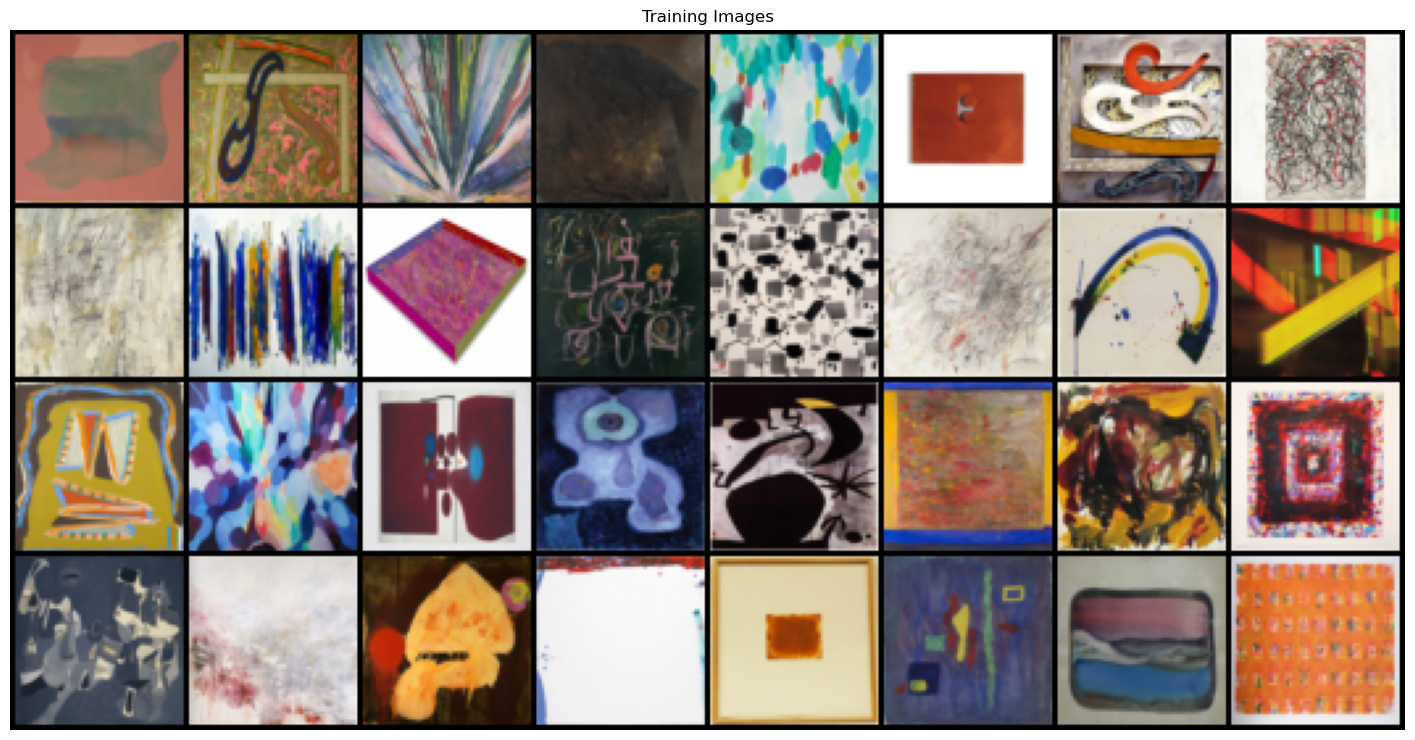

In [96]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")

# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

In [97]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [98]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [99]:
generator = Generator().to(device)
generator.apply(weights_init)

# calculate the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(generator)
print("Trainable Parameters:", count_parameters(generator))

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Trainable Parameters: 3576704


In [100]:
untrained_output = generator(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)

torch.Size([1, 3, 64, 64])


In [101]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [102]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print(discriminator)
print("Trainable Parameters:", count_parameters(discriminator))

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Trainable Parameters: 2765568


In [103]:
discriminator(untrained_output).view(-1).detach()

tensor([0.4898])

In [104]:
criterion = nn.BCELoss()
sampled_noise  = torch.randn(batch_size, latent_size, 1, 1, device=device)

# real is 1 and fake is 0
real_label = 1
fake_label = 0

generator_optim = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [105]:
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator_optim.load_state_dict(checkpoint['generator_optim_state_dict'])
discriminator_optim.load_state_dict(checkpoint['discriminator_optim_state_dict'])

In [106]:
generator_loss = []
discriminator_loss = [] 
iters = 0
img_list = []

In [107]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader)):
        
        # train the discriminator 
        discriminator.zero_grad()
        real_data = data[0].to(device)
        real_size = real_data.size(0)
        
        # [1, 1, 1, 1...., 1]
        label = torch.ones(real_size, dtype=torch.float32, device=device)
        
        output = discriminator(real_data).view(-1)
        # loss on all-real batch
        error_real_batch = criterion(output, label)
        
        # calculate the derivative wrt parameters
        error_real_batch.backward()
        D_x = output.mean().item()
        
        # generating fake data
        noise = torch.randn(real_size, latent_size, 1, 1, device=device)
        fake_data = generator(noise)
        
        # change the label to [0, 0, 0, 0....., 0]
        label.fill_(fake_label)
        
        # classify all fake batch with discriminator 
        output = discriminator(fake_data.detach()).view(-1)
        error_fake_batch = criterion(output, label)
        error_fake_batch.backward()
        
        # the sum of the discriminator 
        error_discriminator = error_real_batch + error_fake_batch
        discriminator_optim.step()
        
        # train the generator 
        generator.zero_grad()
        # pretend the generated results are real 
        label.fill_(real_label)
        
        output = discriminator(fake_data).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        generator_optim.step()
        
        # print out summary statistics 
        if i % 10 == 0:
            tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))
            
        discriminator_loss.append(error_discriminator.item())
        generator_loss.append(error_generator.item())
        
         # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fakes = generator(sampled_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakes, padding=2, normalize=True))

        iters += 1
    

  0%|          | 0/90 [00:03<?, ?it/s]

[0/10][0/90]	Loss_D: 0.2101	Loss_G: 6.9382
[0/10][10/90]	Loss_D: 0.0828	Loss_G: 5.7141
[0/10][20/90]	Loss_D: 0.0575	Loss_G: 6.0705
[0/10][30/90]	Loss_D: 0.1608	Loss_G: 4.4401
[0/10][40/90]	Loss_D: 0.0529	Loss_G: 4.8993
[0/10][50/90]	Loss_D: 0.1341	Loss_G: 4.2453
[0/10][60/90]	Loss_D: 0.0706	Loss_G: 5.1368
[0/10][70/90]	Loss_D: 0.0406	Loss_G: 5.1783
[0/10][80/90]	Loss_D: 0.0299	Loss_G: 6.0955


  0%|          | 0/90 [00:03<?, ?it/s]

[1/10][0/90]	Loss_D: 0.0806	Loss_G: 5.5864
[1/10][10/90]	Loss_D: 0.0647	Loss_G: 6.0272
[1/10][20/90]	Loss_D: 0.1589	Loss_G: 4.5966
[1/10][30/90]	Loss_D: 0.0752	Loss_G: 6.0858
[1/10][40/90]	Loss_D: 0.1312	Loss_G: 4.5886
[1/10][50/90]	Loss_D: 0.1414	Loss_G: 6.6826
[1/10][60/90]	Loss_D: 0.0532	Loss_G: 5.7164
[1/10][70/90]	Loss_D: 0.0633	Loss_G: 5.6298
[1/10][80/90]	Loss_D: 0.0826	Loss_G: 5.5868


  0%|          | 0/90 [00:03<?, ?it/s]

[2/10][0/90]	Loss_D: 0.3271	Loss_G: 8.2120
[2/10][10/90]	Loss_D: 0.0286	Loss_G: 8.0338
[2/10][20/90]	Loss_D: 0.0577	Loss_G: 5.9435
[2/10][30/90]	Loss_D: 0.1124	Loss_G: 5.4395
[2/10][40/90]	Loss_D: 0.0172	Loss_G: 6.7284
[2/10][50/90]	Loss_D: 0.0974	Loss_G: 6.3370
[2/10][60/90]	Loss_D: 0.0222	Loss_G: 7.8224
[2/10][70/90]	Loss_D: 0.0370	Loss_G: 6.5124
[2/10][80/90]	Loss_D: 0.0244	Loss_G: 6.2965


  0%|          | 0/90 [00:03<?, ?it/s]

[3/10][0/90]	Loss_D: 0.0514	Loss_G: 5.2763
[3/10][10/90]	Loss_D: 0.0635	Loss_G: 5.7385
[3/10][20/90]	Loss_D: 0.0597	Loss_G: 6.1046
[3/10][30/90]	Loss_D: 0.1203	Loss_G: 6.5417
[3/10][40/90]	Loss_D: 0.0426	Loss_G: 5.8832
[3/10][50/90]	Loss_D: 0.0314	Loss_G: 5.7982
[3/10][60/90]	Loss_D: 0.1847	Loss_G: 3.9213
[3/10][70/90]	Loss_D: 0.1814	Loss_G: 4.7550
[3/10][80/90]	Loss_D: 0.0317	Loss_G: 6.0789


  0%|          | 0/90 [00:03<?, ?it/s]

[4/10][0/90]	Loss_D: 0.0897	Loss_G: 5.9717
[4/10][10/90]	Loss_D: 0.0418	Loss_G: 5.5963
[4/10][20/90]	Loss_D: 0.1205	Loss_G: 5.3585
[4/10][30/90]	Loss_D: 0.0269	Loss_G: 6.1953
[4/10][40/90]	Loss_D: 0.0243	Loss_G: 5.7119
[4/10][50/90]	Loss_D: 0.0247	Loss_G: 6.1742
[4/10][60/90]	Loss_D: 0.0277	Loss_G: 5.9727
[4/10][70/90]	Loss_D: 0.0509	Loss_G: 5.8519
[4/10][80/90]	Loss_D: 0.0175	Loss_G: 6.0977


  0%|          | 0/90 [00:04<?, ?it/s]

[5/10][0/90]	Loss_D: 0.0238	Loss_G: 5.9003
[5/10][10/90]	Loss_D: 0.0285	Loss_G: 5.6938
[5/10][20/90]	Loss_D: 0.0243	Loss_G: 6.0518
[5/10][30/90]	Loss_D: 0.0194	Loss_G: 6.2183
[5/10][40/90]	Loss_D: 0.1244	Loss_G: 5.0511
[5/10][50/90]	Loss_D: 0.0208	Loss_G: 5.9796
[5/10][60/90]	Loss_D: 0.0563	Loss_G: 4.8264
[5/10][70/90]	Loss_D: 0.1712	Loss_G: 5.3164
[5/10][80/90]	Loss_D: 0.1262	Loss_G: 6.9276


  0%|          | 0/90 [00:04<?, ?it/s]

[6/10][0/90]	Loss_D: 0.0926	Loss_G: 6.6930
[6/10][10/90]	Loss_D: 0.0786	Loss_G: 5.2196
[6/10][20/90]	Loss_D: 0.0432	Loss_G: 5.5073
[6/10][30/90]	Loss_D: 0.5415	Loss_G: 1.3563
[6/10][40/90]	Loss_D: 0.0229	Loss_G: 6.7531
[6/10][50/90]	Loss_D: 1.6253	Loss_G: 0.3287
[6/10][60/90]	Loss_D: 1.0191	Loss_G: 15.8844
[6/10][70/90]	Loss_D: 0.1922	Loss_G: 5.0837
[6/10][80/90]	Loss_D: 0.2011	Loss_G: 7.0391


  0%|          | 0/90 [00:03<?, ?it/s]

[7/10][0/90]	Loss_D: 0.1006	Loss_G: 6.9426
[7/10][10/90]	Loss_D: 0.1949	Loss_G: 5.6894
[7/10][20/90]	Loss_D: 0.1280	Loss_G: 6.4329
[7/10][30/90]	Loss_D: 0.3558	Loss_G: 8.5231
[7/10][40/90]	Loss_D: 0.0951	Loss_G: 5.9931
[7/10][50/90]	Loss_D: 0.3124	Loss_G: 5.1437
[7/10][60/90]	Loss_D: 0.0593	Loss_G: 6.6248
[7/10][70/90]	Loss_D: 0.0596	Loss_G: 5.8973
[7/10][80/90]	Loss_D: 0.0508	Loss_G: 6.8130


  0%|          | 0/90 [00:03<?, ?it/s]

[8/10][0/90]	Loss_D: 0.0323	Loss_G: 6.9554
[8/10][10/90]	Loss_D: 0.0339	Loss_G: 6.8798
[8/10][20/90]	Loss_D: 0.0412	Loss_G: 6.1475
[8/10][30/90]	Loss_D: 0.1654	Loss_G: 7.5304
[8/10][40/90]	Loss_D: 0.0494	Loss_G: 7.2323
[8/10][50/90]	Loss_D: 0.0771	Loss_G: 5.0569
[8/10][60/90]	Loss_D: 0.1047	Loss_G: 5.2181
[8/10][70/90]	Loss_D: 0.0687	Loss_G: 5.9092
[8/10][80/90]	Loss_D: 0.3451	Loss_G: 8.0076


  0%|          | 0/90 [00:04<?, ?it/s]

[9/10][0/90]	Loss_D: 0.0582	Loss_G: 5.1363
[9/10][10/90]	Loss_D: 0.0721	Loss_G: 4.8179
[9/10][20/90]	Loss_D: 0.0297	Loss_G: 7.0301
[9/10][30/90]	Loss_D: 0.0533	Loss_G: 5.6032
[9/10][40/90]	Loss_D: 0.1116	Loss_G: 6.6118
[9/10][50/90]	Loss_D: 0.0596	Loss_G: 5.4135
[9/10][60/90]	Loss_D: 0.1128	Loss_G: 5.9364
[9/10][70/90]	Loss_D: 0.0427	Loss_G: 5.4842
[9/10][80/90]	Loss_D: 0.1086	Loss_G: 5.3364


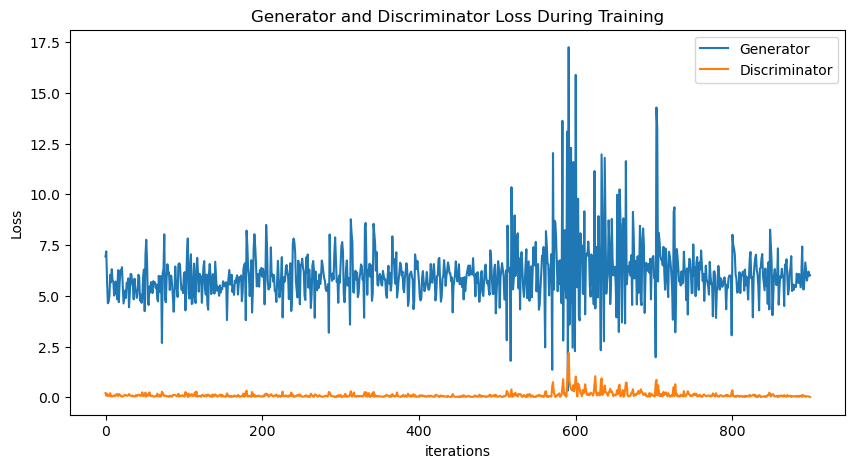

In [108]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

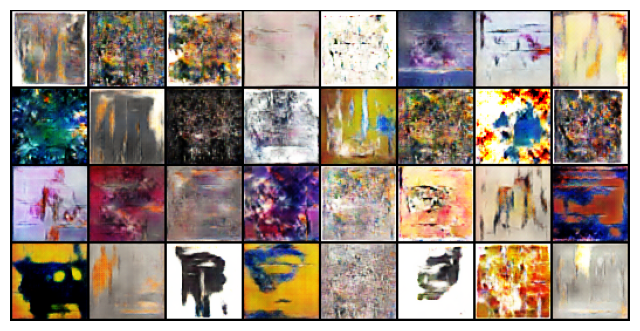

In [111]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [110]:
end_epoch = epoch_restore + epochs
save_file = "{}epochs.chkpt".format(end_epoch)

torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optim_state_dict' : generator_optim.state_dict(),
            'discriminator_optim_state_dict' : discriminator_optim.state_dict(),}, save_file)

In [112]:
pip install imageio pillow


Note: you may need to restart the kernel to use updated packages.


In [116]:
import imageio
from PIL import Image
import torchvision.transforms as transforms

# 从图像列表创建 GIF 动画
def create_gif(image_list, save_path, duration=0.2):
    images = []
    for image in image_list:
        # 将图像从张量格式转换为 PIL 图像格式
        pil_image = transforms.ToPILImage()(image)
        images.append(pil_image)
    
    # 保存为 GIF 动画
    images[0].save(save_path, save_all=True, append_images=images[1:], duration=duration, loop=0, format='GIF')

# 指定生成图像列表和保存路径
image_list = img_list
save_path = "C:/Users/ASUS/miniconda3/envs/coding3/etc/jupyter/generated_images.gif"


# 调用函数创建 GIF 动画
create_gif(image_list, save_path)
